In [1]:
#!/usr/bin/python
# -*- coding: iso-8859-15 -*-
# Author: adriamoya
# Adapted from https://github.com/sachinruk/deepschool.io/blob/master/DL-Keras_Tensorflow/Lesson%2007%20-%20Word2vec.ipynb

%matplotlib inline
import matplotlib.pyplot as plt

import re
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import Counter
from sklearn.manifold import TSNE

/home/amoya/coding/bcpnews/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


In [2]:
# load data
df = pd.read_csv("/home/amoya/.kaggle/competitions/bcpnews/train.csv")
df_test = pd.read_csv("/home/amoya/.kaggle/competitions/bcpnews/test.csv")

In [3]:
def preprocessing(df, column="text"):

    """ Preprocessing (lower case, remove urls, punctuations) """

    print("\nPreprocessing %s ..." % column)

    # preprocessing steps: lower case, remove urls, punctuations ...
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r'http[\w:/\.]+','') # remove urls
    df[column] = df[column].str.replace(r'[^\.(a-zA-ZÀ-ÿ0-9)\s]','') #remove everything but characters and punctuation ( [^\.\w\s] )
    df[column] = df[column].str.replace(r'(?<=\d)(\.)(?=\d)','') #remove dots in thousands (careful with decimals!)
    df[column] = df[column].str.replace(r'\.\.+','.') #replace multple periods with a single one
    df[column] = df[column].str.replace(r'\.',' .') #replace multple periods with a single one
    df[column] = df[column].str.replace(r'\(',' ') # replace brackets with white spaces
    df[column] = df[column].str.replace(r'\)',' ') # replace brackets with white spaces
    df[column] = df[column].str.replace(r'\s\s+',' ') #replace multple white space with a single one
    df[column] = df[column].str.strip()

    return df

In [4]:
df = preprocessing(df, 'text')


Preprocessing text ...


In [5]:
all_text = ''.join(df.text.values)
words = all_text.split()

In [6]:
len(words)

7969637

In [7]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 110829], ('de', 575428), ('la', 304341), ('.', 258977), ('el', 252128)]
Sample data [9, 1029, 1281, 10, 33, 1, 2427, 31, 2330, 534]


In [8]:
%%time
skip_window = 1
instances = len(data) - 2*skip_window
context = np.zeros((instances,skip_window*2+1),dtype=np.int32)
labels = np.zeros((instances,1),dtype=np.int32)

k = 0
for i in range(skip_window, len(data)-skip_window):
    context[k] = data[i-skip_window:i+skip_window+1] # Get surrounding words
    labels[k] = data[i] # Get target variable
    k += 1
    
context = np.delete(context,skip_window,1) # delete the middle word
    
############################
# Chunk the data to be passed into the tensorflow Model
###########################
data_idx = 0
def generate_batch(batch_size):
    global data_idx

    if data_idx+batch_size<instances:
        batch_labels = labels[data_idx:data_idx+batch_size]
        batch_word_data = context[data_idx:data_idx+batch_size]
        data_idx += batch_size
    else:
        overlay = batch_size - (instances-data_idx)
        batch_labels = np.vstack([labels[data_idx:instances],labels[:overlay]])
        batch_word_data = np.vstack([context[data_idx:instances],context[:overlay]])
        data_idx = overlay
    batch_word_data = np.reshape(batch_word_data,(-1,1))

    return batch_labels, batch_word_data

CPU times: user 12.2 s, sys: 80 ms, total: 12.3 s
Wall time: 13.7 s


In [9]:
print([reverse_dictionary[bi] for bi in data[:40]])

['los', 'nueve', 'consejeros', 'del', 'banco', 'de', 'inglaterra', 'han', 'acordado', 'mantener', 'los', 'tipos', 'de', 'interés', 'en', 'el', '025', '.', 'su', 'mayor', 'optimismo', 'sobre', '2017', 'enfría', 'las', 'opciones', 'de', 'una', 'futura', 'rebaja', 'de', 'tipos', '.', 'la', 'reunión', 'del', 'banco', 'de', 'inglaterra', 'ha']


In [10]:
len(data)

7969637

In [11]:
labels_, batch = generate_batch(20)
print('batch:\t', [reverse_dictionary[bi] for bi in batch.ravel()])
print('labels:\t', [reverse_dictionary[li] for li in labels_.ravel()])

batch:	 ['los', 'consejeros', 'nueve', 'del', 'consejeros', 'banco', 'del', 'de', 'banco', 'inglaterra', 'de', 'han', 'inglaterra', 'acordado', 'han', 'mantener', 'acordado', 'los', 'mantener', 'tipos', 'los', 'de', 'tipos', 'interés', 'de', 'en', 'interés', 'el', 'en', '025', 'el', '.', '025', 'su', '.', 'mayor', 'su', 'optimismo', 'mayor', 'sobre']
labels:	 ['nueve', 'consejeros', 'del', 'banco', 'de', 'inglaterra', 'han', 'acordado', 'mantener', 'los', 'tipos', 'de', 'interés', 'en', 'el', '025', '.', 'su', 'mayor', 'optimismo']


Shuffle data:

In [12]:
data_idx = 0
shuffle_idx = np.random.permutation(instances) # create a random permutation to shuffle
labels = labels[shuffle_idx]
context = context[shuffle_idx]

# Tensorflow model: (Continuous Bag of Words - CBoW)

In [13]:
context_window = 2*skip_window
batch_size = 128*context_window
embedding_size = 128 # Dimension of the embedding vector.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_examples = np.random.choice(100,16,replace=False) # Choose 16 words from top 100
num_sampled = 64 # Number of negative examples to sample.

sum_ids = np.repeat(np.arange(batch_size/context_window, dtype=np.int32),context_window)

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size/context_window, 1])
    segment_ids = tf.constant(sum_ids, dtype=tf.int32)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]),trainable=False)

    # Model.
    # Look up embeddings for inputs.
    embed = tf.segment_mean(tf.nn.embedding_lookup(embeddings, train_dataset),segment_ids)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, inputs=embed,
                                   labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [52]:
num_steps = 200001 # 200001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_labels, batch_data = generate_batch(int(batch_size/context_window))
        feed_dict = {train_dataset : batch_data.ravel(), train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        ############
        # Calculate average loss (every 2000 steps)
        ################
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        ####################
        
        ##################
        # Check with the validation set (every 10000 steps)
        ##################
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(len(valid_examples)):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word) # append the k-the nearest word
                print(log)

    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.613335
Nearest to mayor: bandolera, activó, m12, apagadas, elevaron, combinamos, aprovecharía, yanes,
Nearest to durante: prototipo, ryder, extraordinaria, prestaban, hang, museum, pedirán, multicanal,
Nearest to más: alabanzas, parido, carpio, guinda, palco, isde, iñurrategi, bajas,
Nearest to caso: shere, 1920, gestionan, frans, delictivas, notoria, trail, posada,
Nearest to por: sencillos, maquillar, pazo, transurban, reservorio, epinium, editores, terelu,
Nearest to parte: .mapfre, impiden, desconectarse, ingreso, asegurando, seascooter, perdonan, mutuales,
Nearest to capital: ascienden, consolidación, ganes, 2309, actualizarla, metálicos, gordos, retasar,
Nearest to esta: cualificaciones, motocicleta, ocasionado, des, atrasos, mirador, literalmente, introducida,
Nearest to bancos: tenerse, suez, lifting, trillones, afganistán, interferencia, tobacco, anales,
Nearest to año: ferro, sectaria, políticamente, diversificada, quita, castellanos, reg

Average loss at step 52000: 2.365812
Average loss at step 54000: 2.358146
Average loss at step 56000: 2.345936
Average loss at step 58000: 2.336943
Average loss at step 60000: 2.332231
Nearest to mayor: gran, menor, peor, creciente, fuerte, activó, total, plena,
Nearest to durante: en, tras, desde, ante, mediante, edificar, para, con,
Nearest to más: muy, menos, tan, peor, múltiplo, ocultas, sentada, bastante,
Nearest to caso: 1920, momento, mediador, tipo, trataba, secesionistas, féretro, 3465,
Nearest to por: janin, transurban, tras, maquillar, reservorio, durante, ante, judit,
Nearest to parte: ingreso, señal, suerte, contienda, debajo, embarazo, trazas, establecieron,
Nearest to capital: haberlo, gordos, ubp, periférico, idg, dinero, prórrogas, clifford,
Nearest to esta: esa, la, una, alguna, dicha, misma, nuestra, otra,
Nearest to bancos: inversores, sectores, grupos, consumidores, hogares, fondos, liberarán, clientes,
Nearest to año: ejercicio, mes, trimestre, jueves, día, mundo,

Average loss at step 112000: 2.131414
Average loss at step 114000: 2.124939
Average loss at step 116000: 2.119458
Average loss at step 118000: 2.114326
Average loss at step 120000: 2.114393
Nearest to mayor: menor, gran, peor, creciente, fuerte, activó, principal, total,
Nearest to durante: en, tras, ante, mediante, edificar, desde, seré, con,
Nearest to más: menos, muy, peor, tan, bastante, demasiado, especialmente, realmente,
Nearest to caso: momento, 1920, mediador, sillón, opinión, denunciando, féretro, trataba,
Nearest to por: janin, judit, maquillar, transurban, 820, reservorio, meat, novaciones,
Nearest to parte: señal, embarazo, ingreso, debajo, suerte, anunciada, apuesta, ciberataque,
Nearest to capital: dinero, haberlo, ubp, gordos, idg, prórrogas, despachar, poste,
Nearest to esta: esa, dicha, la, una, alguna, aquella, misma, otra,
Nearest to bancos: consumidores, inversores, grupos, partidos, hogares, fondos, accionistas, equipos,
Nearest to año: ejercicio, mes, trimestre, 

Average loss at step 172000: 2.007689
Average loss at step 174000: 2.012422
Average loss at step 176000: 2.008190
Average loss at step 178000: 2.004185
Average loss at step 180000: 2.000023
Nearest to mayor: menor, gran, creciente, peor, fuerte, enorme, cierta, escasa,
Nearest to durante: tras, en, ante, mediante, seré, hogue, anne, period,
Nearest to más: menos, muy, peor, bastante, demasiado, tan, especialmente, realmente,
Nearest to caso: momento, 1920, sillón, mediador, denunciando, féretro, bloque, opinión,
Nearest to por: janin, judit, maquillar, 820, meat, novaciones, transurban, reservorio,
Nearest to parte: embarazo, señal, suerte, apuesta, debajo, zubizarreta, similitud, ingreso,
Nearest to capital: dinero, poste, idg, prórrogas, despachar, agricole, haberlo, ubp,
Nearest to esta: esa, dicha, una, la, alguna, aquella, otra, misma,
Nearest to bancos: inversores, consumidores, partidos, grupos, hogares, banqueros, fondos, accionistas,
Nearest to año: ejercicio, mes, trimestre, 

In [53]:
final_embeddings.shape

(50000, 128)

In [50]:
reverse_dictionary[0]

'UNK'

In [20]:
dictionary['santander']

108

In [54]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

idx = km.fit_predict(final_embeddings)

word_centroid_map = dict(zip(reverse_dictionary, idx ))

clusters = km.labels_.tolist()

In [55]:
word_centroid_map

{0: 1,
 1: 0,
 2: 2,
 3: 3,
 4: 1,
 5: 3,
 6: 0,
 7: 0,
 8: 0,
 9: 4,
 10: 1,
 11: 1,
 12: 4,
 13: 0,
 14: 3,
 15: 0,
 16: 0,
 17: 2,
 18: 0,
 19: 3,
 20: 3,
 21: 0,
 22: 1,
 23: 3,
 24: 3,
 25: 3,
 26: 4,
 27: 3,
 28: 4,
 29: 4,
 30: 0,
 31: 0,
 32: 1,
 33: 1,
 34: 2,
 35: 0,
 36: 4,
 37: 0,
 38: 4,
 39: 0,
 40: 0,
 41: 3,
 42: 2,
 43: 3,
 44: 4,
 45: 0,
 46: 4,
 47: 0,
 48: 3,
 49: 2,
 50: 4,
 51: 0,
 52: 1,
 53: 2,
 54: 3,
 55: 2,
 56: 3,
 57: 3,
 58: 1,
 59: 2,
 60: 3,
 61: 0,
 62: 1,
 63: 0,
 64: 1,
 65: 0,
 66: 3,
 67: 4,
 68: 0,
 69: 1,
 70: 0,
 71: 1,
 72: 1,
 73: 0,
 74: 0,
 75: 3,
 76: 2,
 77: 0,
 78: 1,
 79: 0,
 80: 1,
 81: 3,
 82: 4,
 83: 2,
 84: 4,
 85: 3,
 86: 4,
 87: 2,
 88: 3,
 89: 0,
 90: 2,
 91: 4,
 92: 4,
 93: 3,
 94: 3,
 95: 0,
 96: 4,
 97: 4,
 98: 1,
 99: 1,
 100: 1,
 101: 4,
 102: 0,
 103: 4,
 104: 3,
 105: 2,
 106: 2,
 107: 1,
 108: 1,
 109: 1,
 110: 2,
 111: 1,
 112: 2,
 113: 3,
 114: 1,
 115: 1,
 116: 2,
 117: 3,
 118: 1,
 119: 2,
 120: 0,
 121: 1,
 122: 1,
 12

In [59]:
for cluster in range(0,5):
    # Print the cluster number
    print("")
    print("")
    print ("\nCluster %d" % cluster)

    # Find all of the words for that cluster number, and print them out
    words = []
    for kw, val in word_centroid_map.items():    # for name, age in list.items():  (for Python 3.x)
        if val == cluster:
            words.append(kw)
            
    words_names = []
    for word in words:
        words_names.append(reverse_dictionary[word])
    
    print(words_names)




Cluster 0
['de', 'en', 'y', 'a', 'se', 'con', 'para', 'ha', 'es', 'o', 'han', 'pero', 'también', 'ya', 'desde', 'está', 'según', 'tiene', 'hay', 'le', 'tras', 'cuando', 'puede', 'aunque', 'fue', 'durante', 'cuenta', 'están', 'hace', 'solo', 'mientras', 'tienen', 'nos', 'será', 'va', 'ante', 'podría', 'pueden', 'había', 'embargo', 'les', 'sino', 'sólo', 'sea', 'debe', 'supone', 'siempre', 'aún', 'explica', 'trata', 'me', 'sigue', 'haya', 'espera', 'pese', 'permite', 'entonces', 'parece', 'quiere', 'sería', 'todavía', 'junto', 'hemos', 'considera', 'señala', 'tendrá', 'asegura', 'fueron', 'van', 'obstante', 'tenido', 'ofrece', 'deben', 'da', 'estamos', 'tenemos', 'asimismo', 'te', 'estaba', 'tenía', 'dijo', 'actualmente', 'efe', 'mantiene', 'hizo', 'prevé', 'señalado', 'pueda', 'nunca', 'apenas', 'podrían', 'finalmente', 'destaca', 'encuentra', 'sitúa', 'incluye', 'serán', 'cree', 'dice', 'lleva', 'añade', 'explicado', 'puedan', 'debería', 'queda', 'apunta', 'anunció', 'habrá', 'exist

['UNK', 'el', 'del', 'un', 'al', 'año', 'banco', 'mercado', 'pasado', 'gobierno', 'sector', 'caso', 'presidente', 'grupo', 'mayor', 'nuevo', 'país', 'uno', 'primer', 'mismo', 'santander', 'e', 'antes', 'después', 'negocio', 'mes', 'frente', 'gran', 'precio', 'valor', 'momento', 'total', 'día', 'tiempo', 'otro', 'tipo', 'crecimiento', 'estado', 'mundo', 'plazo', 'acuerdo', 'objetivo', 'proceso', 'sistema', 'interés', 'medio', 'riesgo', 'trimestre', 'trabajo', 'nivel', '.el', 'cambio', 'plan', 'nacional', 'dinero', 'número', 'consejo', '10', 'último', 'director', 'empleo', 'financiero', 'proyecto', '20', 'fondo', 'ejercicio', 'lugar', '1', 'consejero', 'puesto', 'poder', 'partido', 'bce', 'reino', 'crédito', '15', 'segundo', 'punto', 'resto', 'informe', 'futuro', '30', 'ejecutivo', 'beneficio', 'periodo', 'psoe', 'próximo', 'dentro', 'modelo', 'impacto', 'largo', 'servicio', 'resultado', '50', '3', 'cliente', 'sentido', '2', 'fuera', '25', 'pp', 'cierre', 'desarrollo', 'principal', 'euro

['.', 'que', 'por', 'su', 'no', 'más', 'como', 'lo', 'este', 'sobre', 'si', 'sin', 'todo', 'ser', 'así', 'muy', 'popular', 'ahora', 'sido', 'menos', 'cada', 'hoy', 'porque', 'tanto', 'hecho', 'donde', 'hacer', 'ese', '2017', 'ni', 'tener', 'respecto', 'mejor', 'bien', 'eso', 'contra', 'ello', 'qué', 'sí', 'algo', 'mucho', 'esto', 'español', 'casi', 'social', 'posible', 'unido', 'cualquier', 'cómo', 'poco', 'importante', 'público', 'europeo', 'dar', 'tan', 'ejemplo', 'incluso', 'toda', 'bajo', 'unidos', 'haber', 'ver', 'podemos', 'trump', 'decir', 'estar', 'siendo', 'marcha', 'nuestro', 'superior', 'gracias', 'nada', 'cuanto', 'dicho', 'dado', 'rajoy', 'cabo', '2018', 'seguir', 'hacia', 'llegar', 'reducir', 'clave', 'él', 'laboral', 'concreto', 'mantener', 'ningún', 'fuerte', 'realizar', 'igual', 'evitar', 'mejorar', 'claro', 'especialmente', 'pagar', 'mediante', 'poner', 'visto', 'italia', 'previsto', 'aquí', 'alcanzar', 'pues', 'necesario', 'conocer', 'debido', 'internet', 'crear', 'c

['los', 'las', 'millones', 'euros', 'sus', 'entre', 'hasta', 'años', 'son', 'dos', 'empresas', 'estos', 'tres', 'otros', 'todos', 'bancos', 'meses', 'entidades', 'unos', 'clientes', 'datos', 'estas', 'activos', 'grandes', 'personas', 'otras', 'últimos', 'países', 'puntos', 'servicios', 'inversores', 'acciones', 'través', 'días', 'fondos', 'fuentes', 'ingresos', 'nuevos', 'todas', 'cuatro', 'resultados', 'tipos', 'productos', 'nuevas', 'algunos', 'accionistas', 'cinco', 'precios', 'mercados', 'ellos', 'unas', 'cuentas', 'estados', 'operaciones', 'compañías', 'principales', 'muchos', 'medidas', 'trabajadores', 'partir', 'horas', 'financieras', 'ciudadanos', 'españoles', 'ventas', 'seis', 'primeros', 'condiciones', 'empleados', 'pérdidas', 'costes', 'finales', 'cerca', 'problemas', 'valores', 'algunas', 'sabadell', 'bonos', 'varios', 'mayores', 'oficinas', 'elecciones', 'casos', 'recursos', 'próximos', 'proyectos', 'veces', 'niveles', 'inversiones', 'muchas', 'diferentes', 'usuarios', 'in

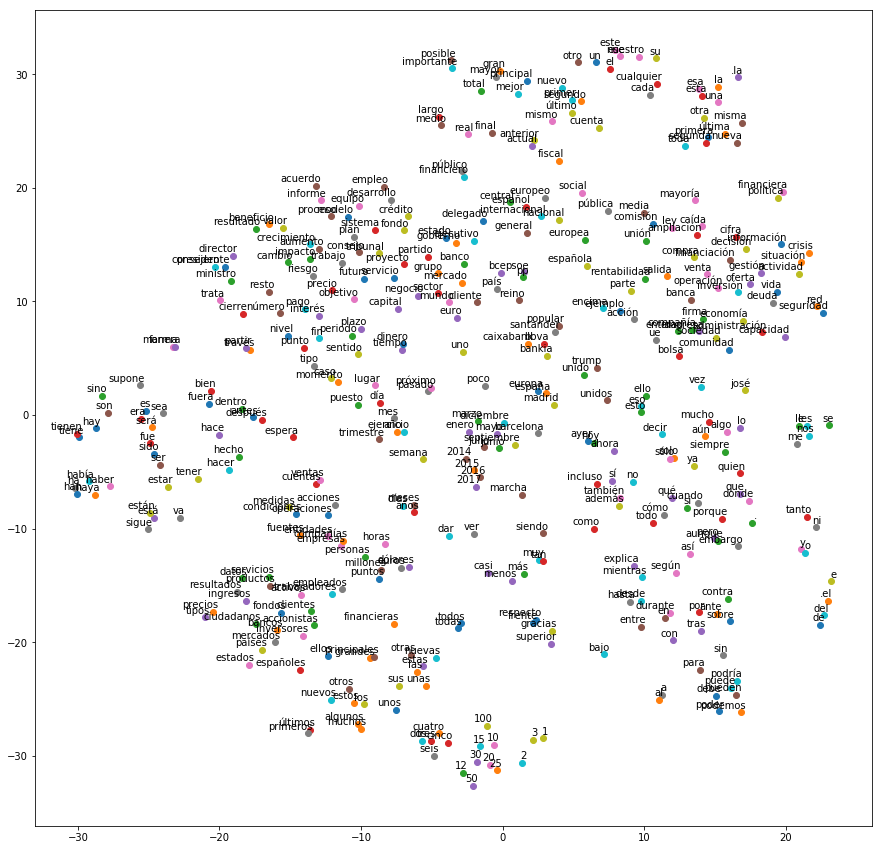

In [17]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    plt.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [22]:
final_embeddings[0]

array([ 6.94914460e-02,  4.42465283e-02, -7.42352828e-02,  1.01415720e-02,
       -3.58189568e-02, -5.85301220e-02, -4.90535013e-02, -1.23210654e-01,
       -1.23552047e-01,  7.31641278e-02, -5.59075065e-02,  3.92964436e-03,
       -8.75197053e-02, -2.74978299e-02, -1.36804534e-02,  8.99771377e-02,
       -4.10998352e-02,  7.20975995e-02, -4.71039824e-02,  1.22763284e-01,
        4.15167101e-02,  1.00400053e-01, -1.38550803e-01, -3.84866185e-02,
       -1.30468518e-01, -2.72211921e-03,  9.07721221e-02,  1.99481979e-01,
       -2.28903979e-01, -7.77671114e-02, -1.05138794e-01, -8.30048695e-02,
        4.97830398e-02, -3.49698646e-04, -3.14399637e-02,  1.11660741e-01,
       -5.48855439e-02, -7.50376806e-02,  7.89282396e-02, -8.29311386e-02,
        9.19567272e-02,  1.91365350e-02,  4.47493717e-02,  2.01844107e-02,
        6.74371645e-02,  2.06936181e-01,  5.63977333e-03,  5.77792004e-02,
        1.70167089e-01,  1.43169090e-01,  5.80377020e-02, -1.36544695e-02,
        6.64065545e-03, -